# RL Flappy Bird Assignment

Thomas LEMERCIER

Environment import and setup

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

import text_flappy_bird_gym

from tqdm import tqdm
import numpy as np

from src.utils.visualization import plot_state_value_function

In [2]:
# Global variables for the evaluation
max_steps_for_evaluation = 1000
num_episodes_for_evaluation = 2000

## Reference agent: Random agent

In [3]:
def play_random_episode(env):
    env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = env.action_space.sample()
        _, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

def evaluate_random_policy(env):
    total_rewards = []
    for _ in tqdm(range(num_episodes_for_evaluation)):
        total_reward = play_random_episode(env)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:00<00:00, 6484.59it/s]


Mean total reward 11.3385
Std total reward 5.5793295072078335
Max total reward 50
Min total reward 4
Quartiles [ 7.  12.5 13. ]


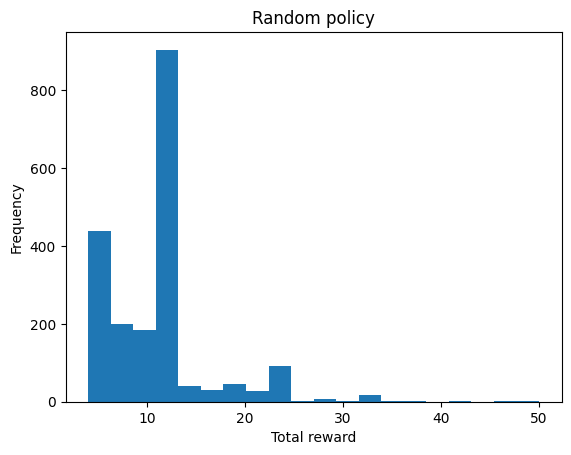

In [55]:
total_rewards = evaluate_random_policy(gym.make('TextFlappyBird-v0'))
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Random policy')
plt.show()

## First agent: Sarsa ($\lambda$)

In [4]:
from src.agents import SarsaLambdaAgent
from src.exploration_policy import EpsilonGreedy
from src.utils.data_structures import Transition, SarsaLambdaParams

def train_sarsa_lambda(params, epsilon, num_episodes, max_train_steps, verbose=False):
    env = gym.make('TextFlappyBird-v0')
    agent = SarsaLambdaAgent(params, EpsilonGreedy(epsilon))

    loader = tqdm(range(num_episodes)) if verbose else range(num_episodes)
    
    rewards = np.zeros(num_episodes)
    for episode in loader:
        state, _ = env.reset()
        action = agent.act(state)
        total_reward = 0
        for _ in range(max_train_steps):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.act(next_state)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition, next_action)
            total_reward += reward
            if done:
                break
            state = next_state
            action = next_action
        rewards[episode] = total_reward
    return agent, rewards

def play_sarsa_lambda_episode(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = agent.get_best_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

def evaluate_sarsa_lambda(env, agent, verbose=False):
    loader = tqdm(range(num_episodes_for_evaluation)) if verbose else range(num_episodes_for_evaluation)

    total_rewards = []
    for _ in loader:
        total_reward = play_sarsa_lambda_episode(env, agent)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:22<00:00, 87.95it/s]


Mean total reward 1000.0
Std total reward 0.0
Max total reward 1000
Min total reward 1000
Quartiles [1000. 1000. 1000.]


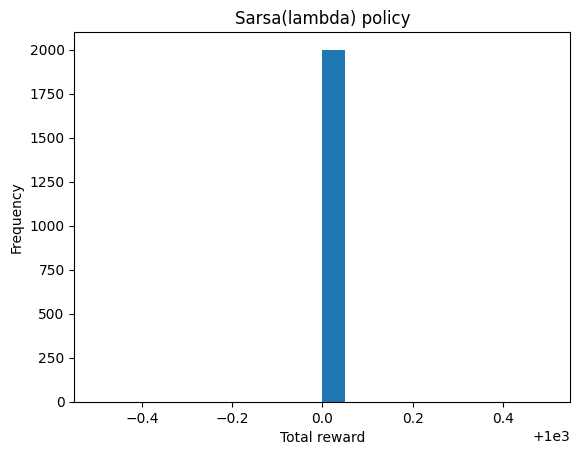

In [57]:
params = SarsaLambdaParams(alpha=0.05, gamma=0.9, num_actions=2, lambd=0.99)
agent, rewards = train_sarsa_lambda(params, epsilon=0.1, num_episodes=10000, max_train_steps=1000, verbose=True)
total_rewards = evaluate_sarsa_lambda(gym.make('TextFlappyBird-v0'), agent, verbose=True)
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Sarsa(lambda) policy')
plt.show()

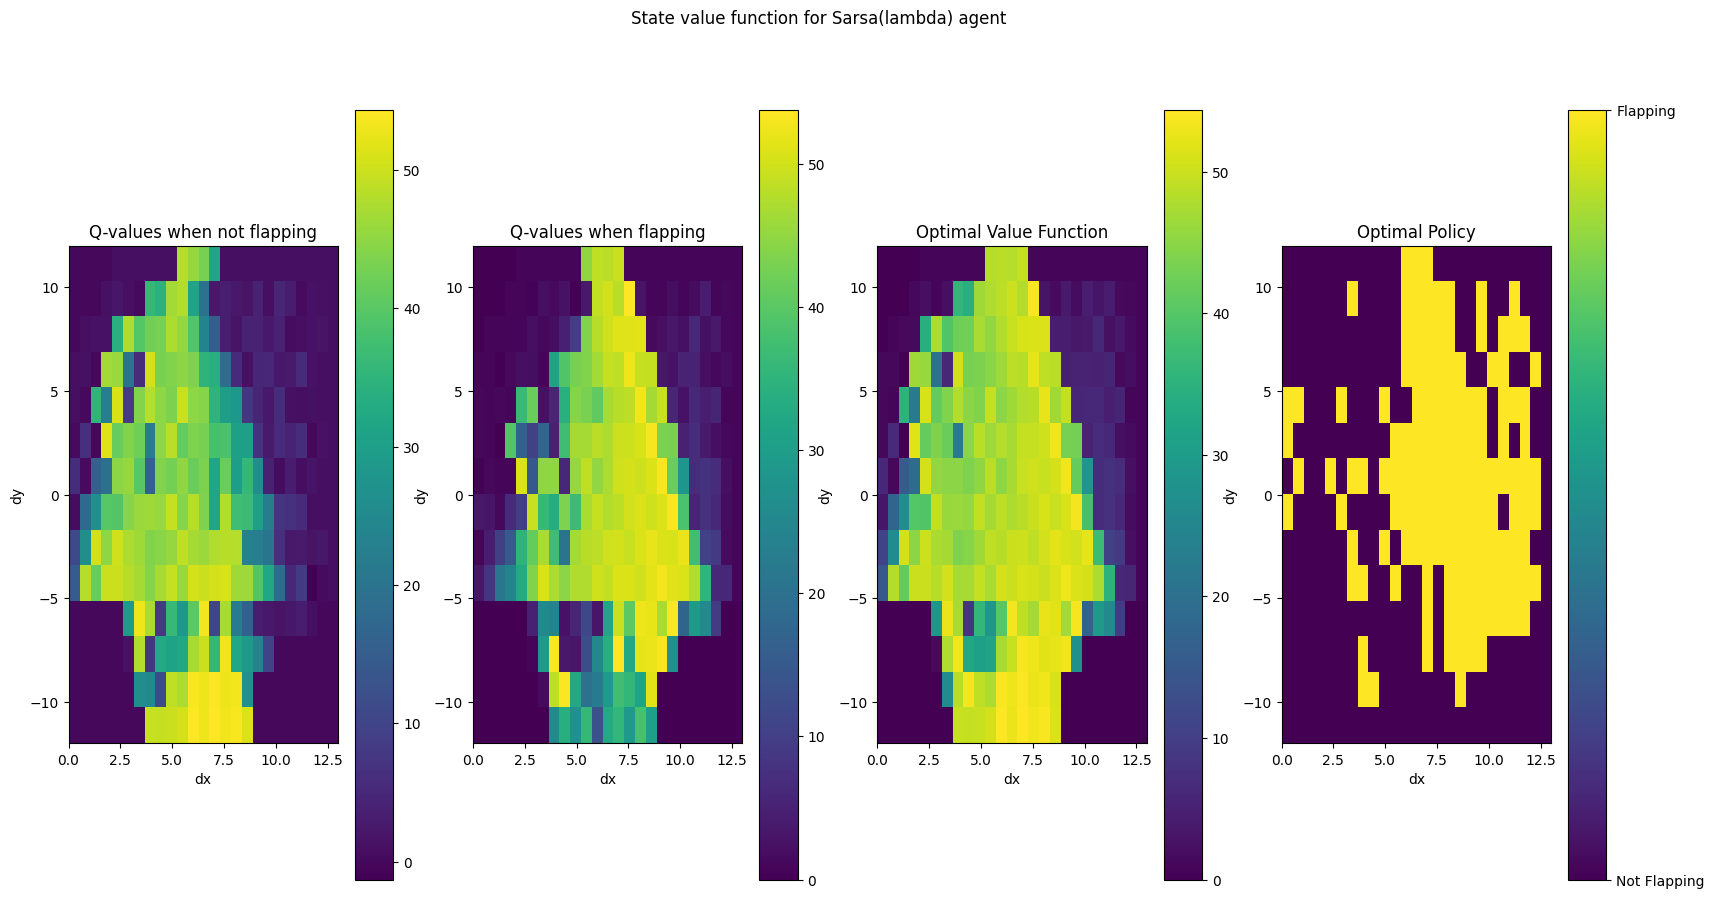

In [58]:
plot_stat_vealue_function(agent.q_values, 'State value function for Sarsa(lambda) agent')

## Second agent: Off-policy Monte Carlo control

In [5]:
from src.agents import OffPolicyMonteCarloAgent
from src.utils.data_structures import MonteCarloParams

def train_off_policy_monte_carlo(params, num_episodes, max_train_steps, verbose=False):
    env = gym.make('TextFlappyBird-v0')
    agent = OffPolicyMonteCarloAgent(params)

    loader = tqdm(range(num_episodes)) if verbose else range(num_episodes)
    
    rewards = np.zeros(num_episodes)
    for episode in loader:
        state, _ = env.reset()
        total_reward = 0
        episode_transitions = []
        for _ in range(max_train_steps):
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            episode_transitions.append((state, action, reward))
            total_reward += reward
            if done:
                break
            state = next_state
        agent.update(episode_transitions)
        rewards[episode] = total_reward
    return agent, rewards

def play_off_policy_monte_carlo_episode(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = agent.get_best_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

def evaluate_off_policy_monte_carlo(env, agent, verbose=False):
    loader = tqdm(range(num_episodes_for_evaluation)) if verbose else range(num_episodes_for_evaluation)

    total_rewards = []
    for _ in loader:
        total_reward = play_off_policy_monte_carlo_episode(env, agent)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:15<00:00, 126.68it/s]


Mean total reward 718.6065
Std total reward 339.01740022858706
Max total reward 1000
Min total reward 23
Quartiles [ 423.  953. 1000.]


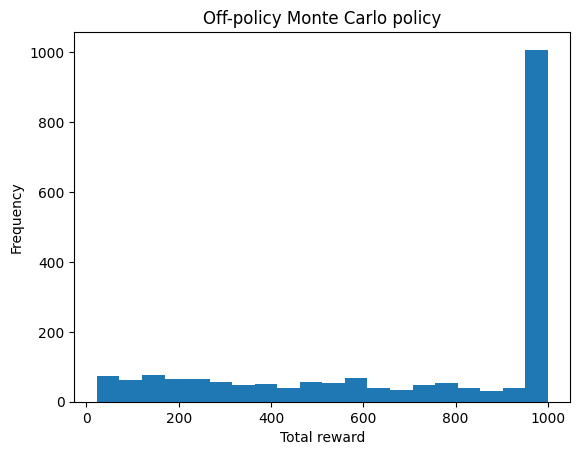

In [60]:
params = MonteCarloParams(num_actions=2, gamma=0.9, epsilon=0.1)
agent, rewards = train_off_policy_monte_carlo(params, num_episodes=10000, max_train_steps=200, verbose=True)
total_rewards = evaluate_off_policy_monte_carlo(gym.make('TextFlappyBird-v0'), agent, verbose=True)
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Off-policy Monte Carlo policy')
plt.show()

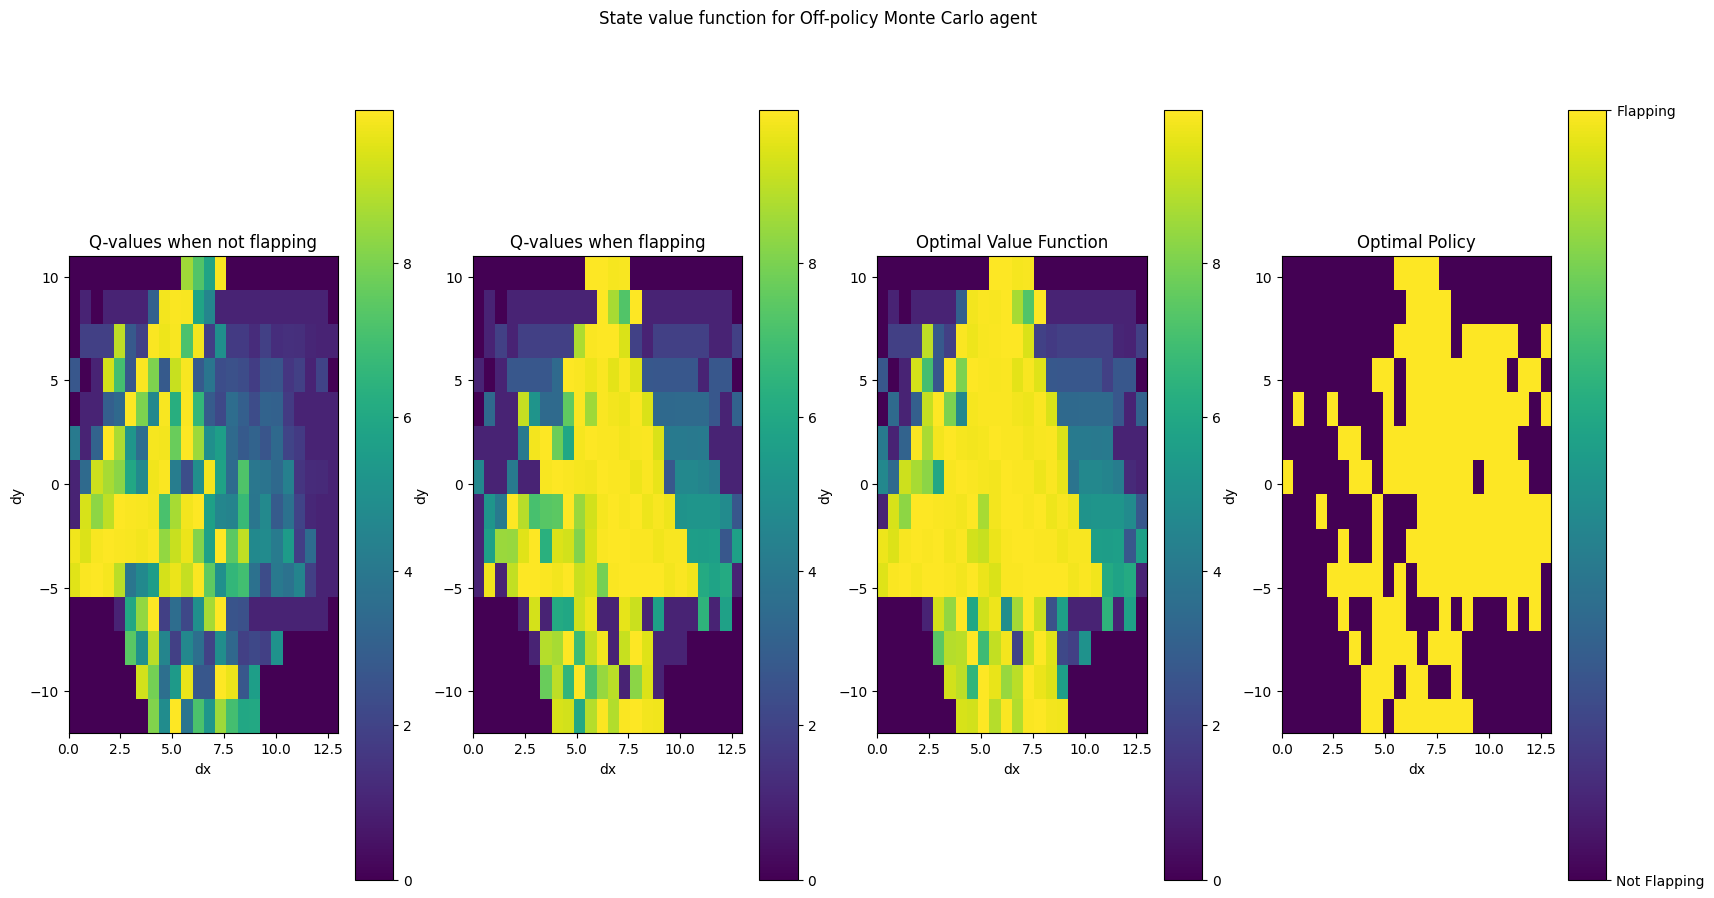

In [61]:
plot_state_value_function(agent.q_values, 'State value function for Off-policy Monte Carlo agent')

## Additional agent: Q-learning

In [6]:
from src.agents import QLearningAgent
from src.utils.data_structures import QLearningParams

def train_q_learning(params, epsilon, num_episodes, max_train_steps, verbose=False):
    env = gym.make('TextFlappyBird-v0')
    agent = QLearningAgent(params, EpsilonGreedy(epsilon))

    loader = tqdm(range(num_episodes)) if verbose else range(num_episodes)
    
    rewards = np.zeros(num_episodes)
    for episode in loader:
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_train_steps):
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition)
            total_reward += reward
            if done:
                break
            state = next_state
        rewards[episode] = total_reward
    return agent, rewards

def play_q_learning_episode(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = agent.get_best_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

def evaluate_q_learning(env, agent, verbose=False):
    loader = tqdm(range(num_episodes_for_evaluation)) if verbose else range(num_episodes_for_evaluation)

    total_rewards = []
    for _ in loader:
        total_reward = play_q_learning_episode(env, agent)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:23<00:00, 85.88it/s]


Mean total reward 1000.0
Std total reward 0.0
Max total reward 1000
Min total reward 1000
Quartiles [1000. 1000. 1000.]


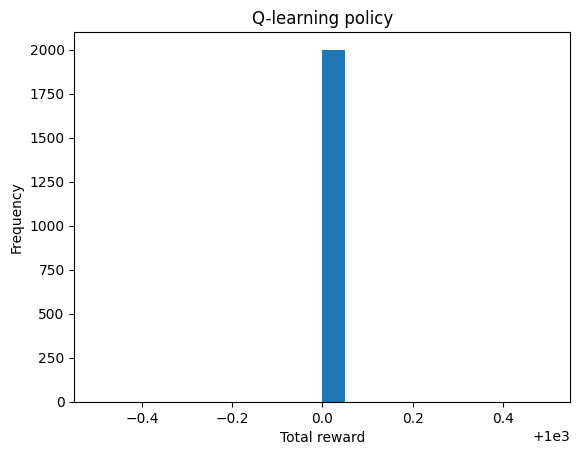

In [63]:
params = QLearningParams(alpha=0.05, gamma=0.9, num_actions=2)
agent, rewards = train_q_learning(params, epsilon=0.1, num_episodes=50000, max_train_steps=1000, verbose=True)
total_rewards = evaluate_q_learning(gym.make('TextFlappyBird-v0'), agent, verbose=True)
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Q-learning policy')
plt.show()

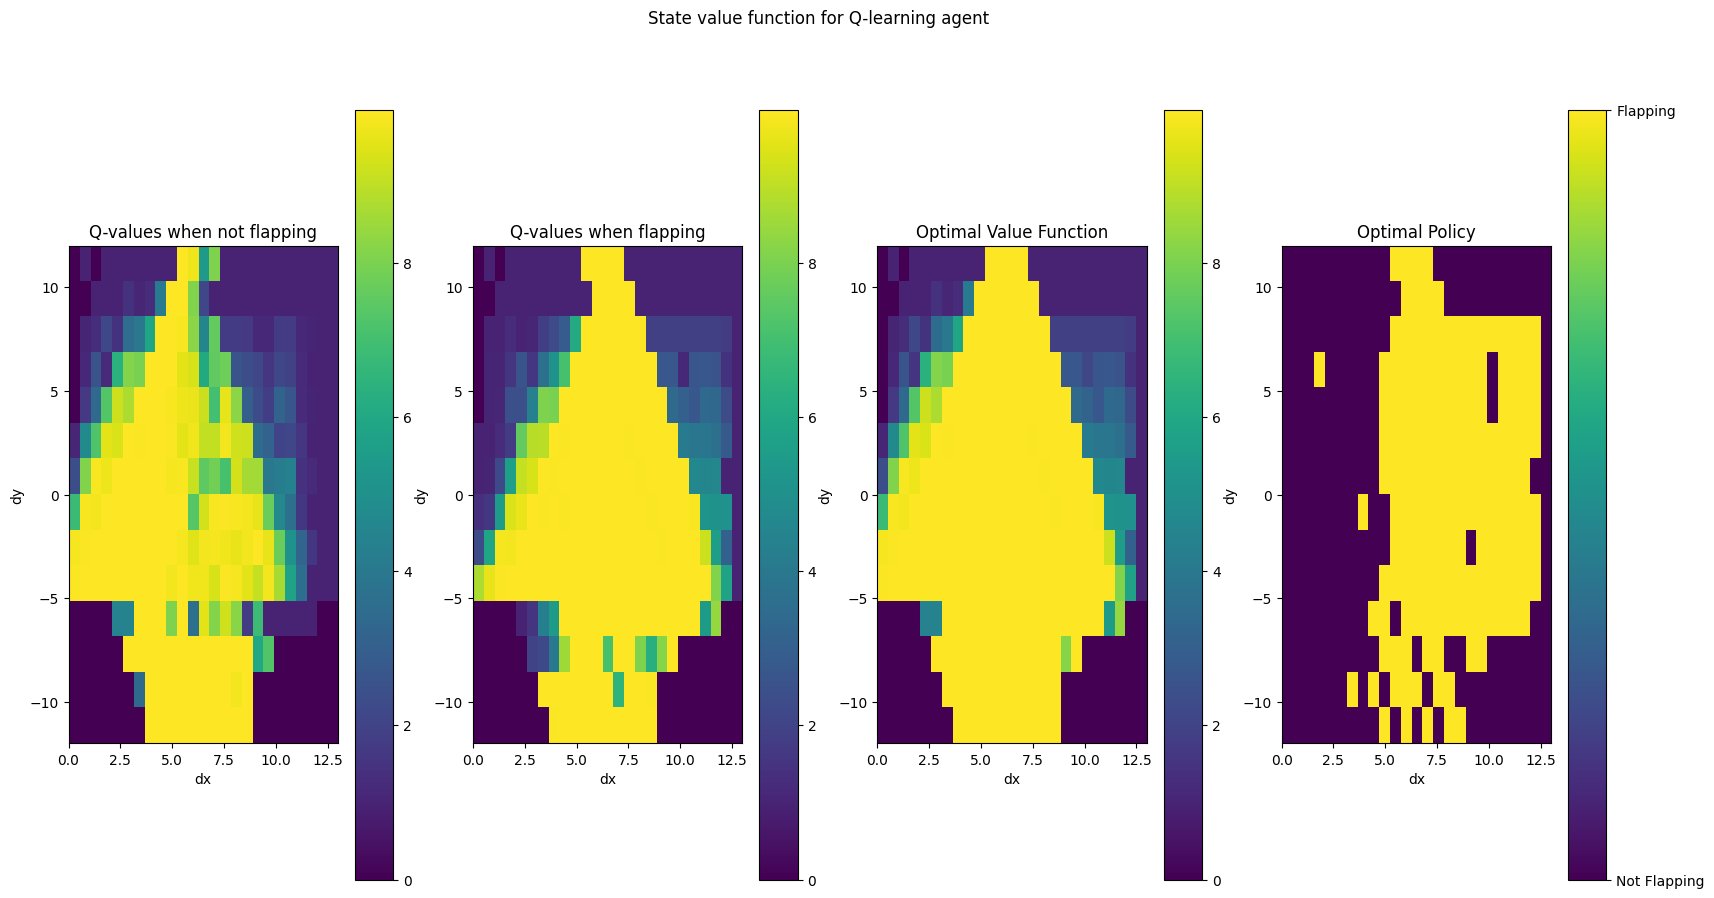

In [64]:
plot_state_value_function(agent.q_values, 'State value function for Q-learning agent')

## Additional agent: Sarsa

In [7]:
from src.agents import SarsaAgent
from src.utils.data_structures import SarsaParams

def train_sarsa(params, epsilon, num_episodes, max_train_steps, verbose=False):
    env = gym.make('TextFlappyBird-v0')
    agent = SarsaAgent(params, EpsilonGreedy(epsilon))

    loader = tqdm(range(num_episodes)) if verbose else range(num_episodes)
    
    rewards = np.zeros(num_episodes)
    for episode in loader:
        state, _ = env.reset()
        action = agent.act(state)
        total_reward = 0
        for _ in range(max_train_steps):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.act(next_state)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition, next_action)
            total_reward += reward
            if done:
                break
            state = next_state
            action = next_action
        rewards[episode] = total_reward
    return agent, rewards

def play_sarsa_episode(env, agent):
    state, _ = env.reset()
    done = False
    total_reward = 0
    for  _ in range(max_steps_for_evaluation):
        action = agent.get_best_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

def evaluate_sarsa(env, agent, verbose=False):
    loader = tqdm(range(num_episodes_for_evaluation)) if verbose else range(num_episodes_for_evaluation)

    total_rewards = []
    for _ in loader:
        total_reward = play_sarsa_episode(env, agent)
        total_rewards.append(total_reward)
    return total_rewards

100%|██████████| 2000/2000 [00:23<00:00, 83.35it/s]


Mean total reward 1000.0
Std total reward 0.0
Max total reward 1000
Min total reward 1000
Quartiles [1000. 1000. 1000.]


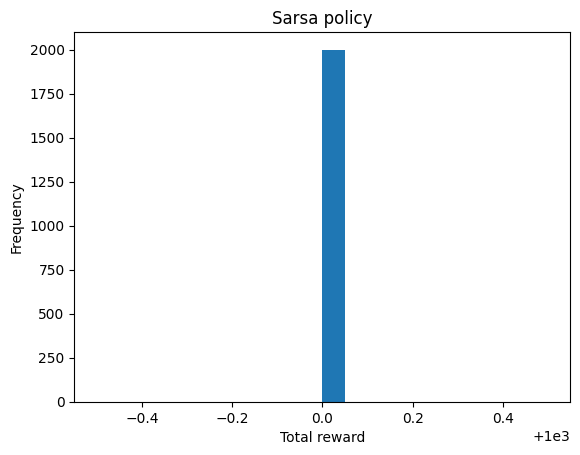

In [66]:
params = SarsaParams(alpha=0.05, gamma=0.9, num_actions=2)
agent, rewards = train_sarsa(params, epsilon=0.1, num_episodes=50000, max_train_steps=1000, verbose=True)
total_rewards = evaluate_sarsa(gym.make('TextFlappyBird-v0'), agent, verbose=True)
print('Mean total reward', np.mean(total_rewards))
print('Std total reward', np.std(total_rewards))
print('Max total reward', np.max(total_rewards))
print('Min total reward', np.min(total_rewards))
print('Quartiles', np.percentile(total_rewards, [25, 50, 75]))
plt.hist(total_rewards, bins=20)
plt.xlabel('Total reward')
plt.ylabel('Frequency')
plt.title('Sarsa policy')
plt.show()

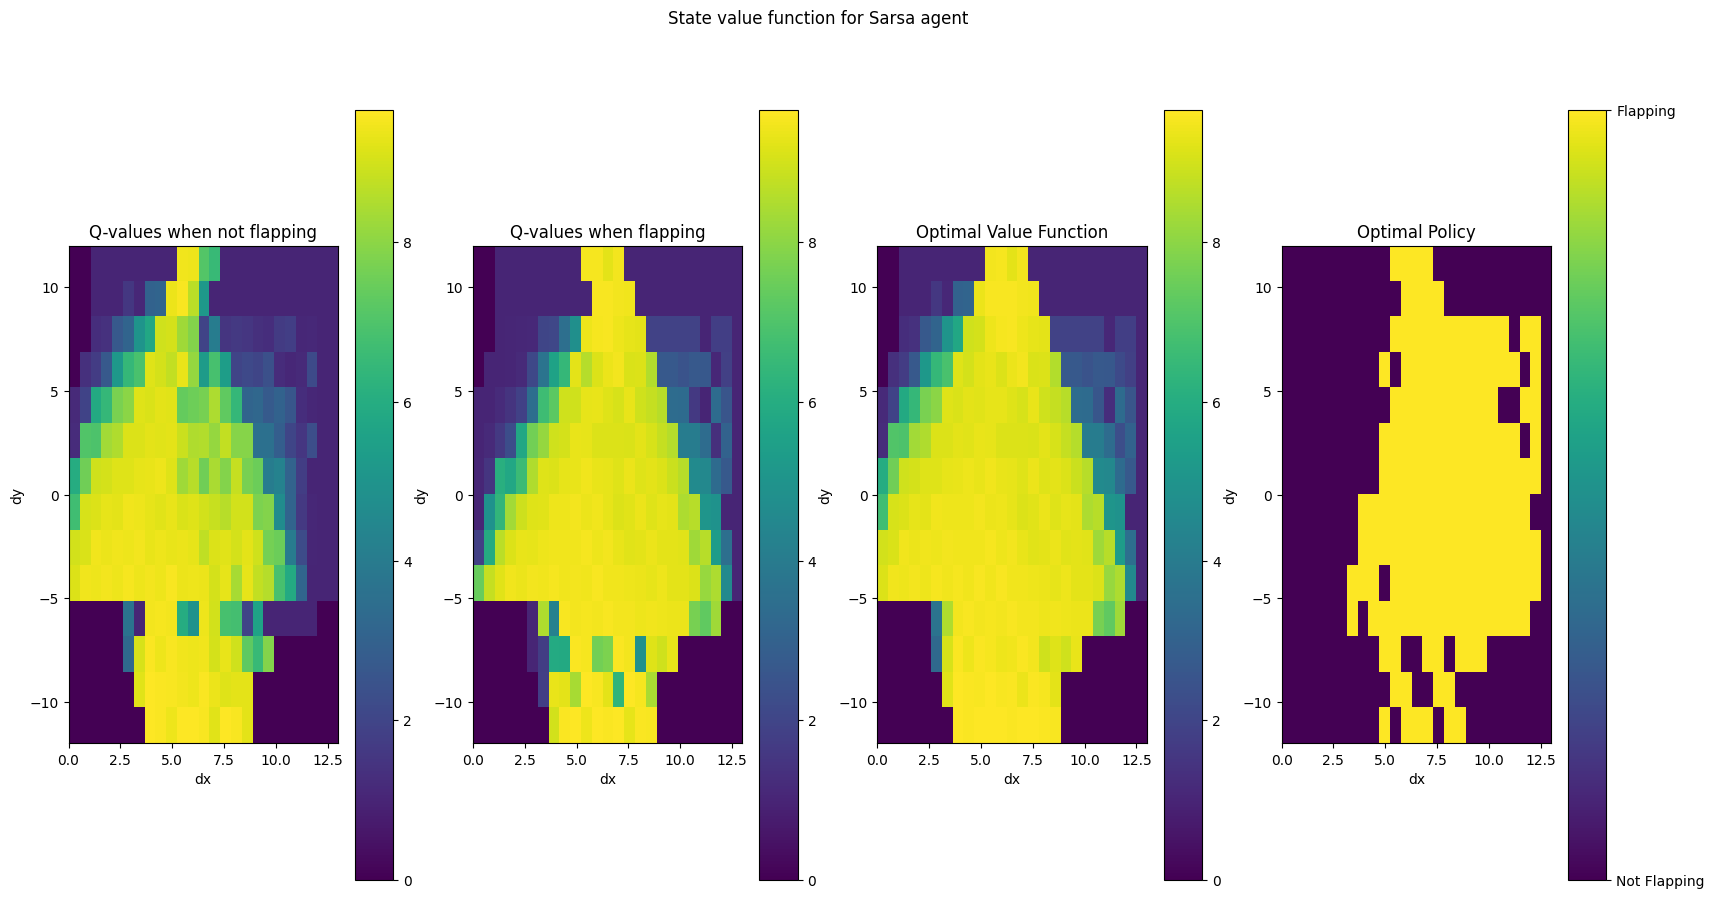

In [67]:
plot_state_value_function(agent.q_values, 'State value function for Sarsa agent')

## Perfomance analysis

### Fixed parameters

In [8]:
num_performance_runs = 10
num_algo_to_evaluate = 4 # Sarsa(lambda), Off-policy Monte Carlo, Q-learning, Sarsa

SarsaLambda - Mean total reward: 696.9314, Std total reward: 367.75451980908036


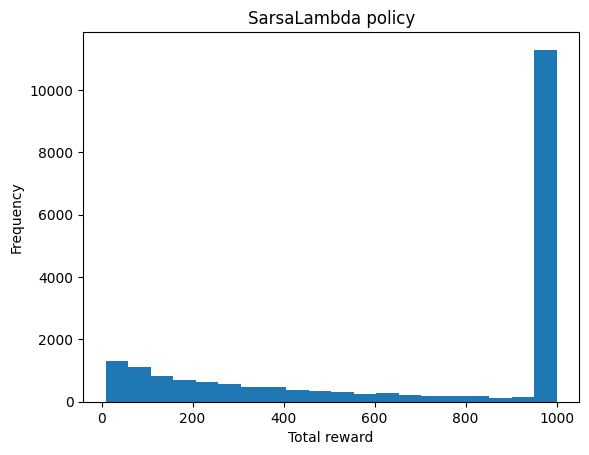

OffPolicyMonteCarlo - Mean total reward: 803.52975, Std total reward: 309.34875808243464


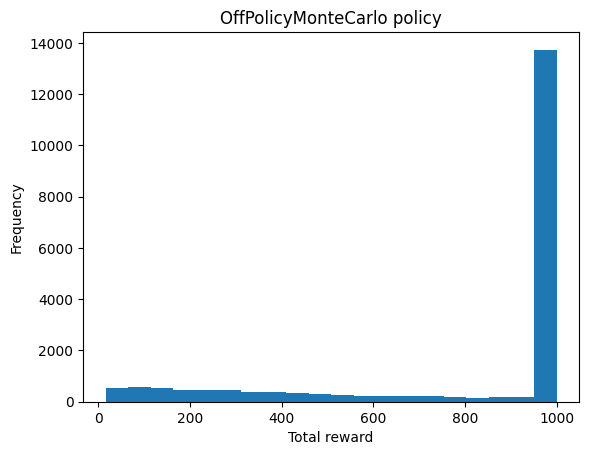

QLearning - Mean total reward: 99.84545, Std total reward: 142.99882255954535


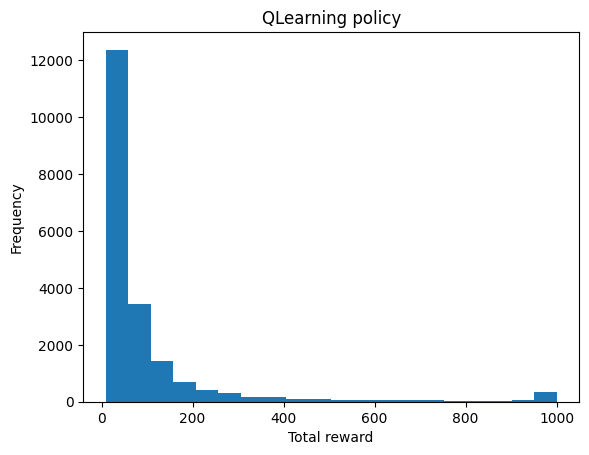

Sarsa - Mean total reward: 61.6442, Std total reward: 53.81724163587266


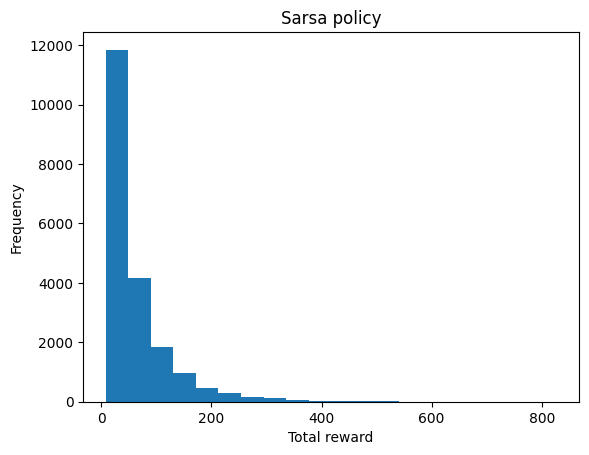

In [17]:
from multiprocessing.pool import ThreadPool as Pool

total_rewards = np.zeros((num_algo_to_evaluate, num_performance_runs, num_episodes_for_evaluation))

def evaluate_agent(agent_class):
    if agent_class == 'SarsaLambda':
        total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
        for k in range(num_performance_runs):
            params = SarsaLambdaParams(alpha=0.05, gamma=0.9, num_actions=2, lambd=0.99)
            agent, _ = train_sarsa_lambda(params, epsilon=0.1, num_episodes=10000, max_train_steps=200)
            total_rewards[k] = evaluate_sarsa_lambda(gym.make('TextFlappyBird-v0'), agent)
        return total_rewards
    elif agent_class == 'OffPolicyMonteCarlo':
        total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
        for k in range(num_performance_runs):
            params = MonteCarloParams(num_actions=2, gamma=0.9, epsilon=0.1)
            agent, _ = train_off_policy_monte_carlo(params, num_episodes=10000, max_train_steps=200)
            total_rewards[k] = evaluate_off_policy_monte_carlo(gym.make('TextFlappyBird-v0'), agent)
        return total_rewards
    elif agent_class == 'QLearning':
        total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
        for k in range(num_performance_runs):
            params = QLearningParams(alpha=0.05, gamma=0.9, num_actions=2)
            agent, _ = train_q_learning(params, epsilon=0.1, num_episodes=10000, max_train_steps=200)
            total_rewards[k] = evaluate_q_learning(gym.make('TextFlappyBird-v0'), agent)
        return total_rewards
    elif agent_class == 'Sarsa':
        total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
        for k in range(num_performance_runs):
            params = SarsaParams(alpha=0.05, gamma=0.9, num_actions=2)
            agent, _ = train_sarsa(params, epsilon=0.1, num_episodes=10000, max_train_steps=200)
            total_rewards[k] = evaluate_sarsa(gym.make('TextFlappyBird-v0'), agent)
        return total_rewards
    else:
        raise ValueError('Invalid agent class')

with Pool(num_performance_runs) as pool:
    for i, total_rewards_for_run in enumerate(pool.imap(evaluate_agent, ['SarsaLambda', 'OffPolicyMonteCarlo', 'QLearning', 'Sarsa'])):
        total_rewards[i] = total_rewards_for_run

mean_total_rewards = np.mean(total_rewards, axis=1)
std_total_rewards = np.std(total_rewards, axis=1)

for i, agent_class in enumerate(['SarsaLambda', 'OffPolicyMonteCarlo', 'QLearning', 'Sarsa']):
    print(f'{agent_class} - Mean total reward: {np.mean(mean_total_rewards[i])}, Std total reward: {np.mean(std_total_rewards[i])}')
    plt.hist(total_rewards[i].flatten(), bins=20)
    plt.xlabel('Total reward')
    plt.ylabel('Frequency')
    plt.title(f'{agent_class} policy')
    plt.show()


### Time analysis

In [9]:
import time

def train_sarsa_lambda_time(params, epsilon, num_episodes, max_train_steps, verbose=False):
    env = gym.make('TextFlappyBird-v0')
    agent = SarsaLambdaAgent(params, EpsilonGreedy(epsilon))

    loader = tqdm(range(num_episodes)) if verbose else range(num_episodes)
    
    rewards = []
    times = []
    top = time.time()
    for episode in loader:
        state, _ = env.reset()
        action = agent.act(state)
        total_reward = 0
        for _ in range(max_train_steps):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.act(next_state)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition, next_action)
            total_reward += reward
            if done:
                break
            state = next_state
            action = next_action
        if episode % 100 == 0:
            rewards.append(play_sarsa_lambda_episode(env, agent))
            times.append(time.time() - top)
    return agent, rewards, times

def train_off_policy_monte_carlo_time(params, num_episodes, max_train_steps, verbose=False):
    env = gym.make('TextFlappyBird-v0')
    agent = OffPolicyMonteCarloAgent(params)

    loader = tqdm(range(num_episodes)) if verbose else range(num_episodes)
    
    rewards = []
    times = []
    top = time.time()
    for episode in loader:
        state, _ = env.reset()
        total_reward = 0
        episode_transitions = []
        for _ in range(max_train_steps):
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            episode_transitions.append((state, action, reward))
            total_reward += reward
            if done:
                break
            state = next_state
        agent.update(episode_transitions)

        if episode % 100 == 0:
            rewards.append(play_off_policy_monte_carlo_episode(env, agent))
            times.append(time.time() - top)
    return agent, rewards, times

def train_q_learning_time(params, epsilon, num_episodes, max_train_steps, verbose=False):
    env = gym.make('TextFlappyBird-v0')
    agent = QLearningAgent(params, EpsilonGreedy(epsilon))

    loader = tqdm(range(num_episodes)) if verbose else range(num_episodes)
    
    rewards = []
    times = []
    top = time.time()
    for episode in loader:
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_train_steps):
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition)
            total_reward += reward
            if done:
                break
            state = next_state
        
        if episode % 100 == 0:
            rewards.append(play_q_learning_episode(env, agent))
            times.append(time.time() - top)
    return agent, rewards, times

def train_sarsa_time(params, epsilon, num_episodes, max_train_steps, verbose=False):
    env = gym.make('TextFlappyBird-v0')
    agent = SarsaAgent(params, EpsilonGreedy(epsilon))

    loader = tqdm(range(num_episodes)) if verbose else range(num_episodes)
    
    rewards = []
    times = []
    top = time.time()
    for episode in loader:
        state, _ = env.reset()
        action = agent.act(state)
        total_reward = 0
        for _ in range(max_train_steps):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.act(next_state)
            transition = Transition(state, action, reward, next_state, done)
            agent.update(transition, next_action)
            total_reward += reward
            if done:
                break
            state = next_state
            action = next_action

        if episode % 100 == 0:
            rewards.append(play_sarsa_episode(env, agent))
            times.append(time.time() - top)
    return agent, rewards, times

100%|██████████| 10000/10000 [04:06<00:00, 40.57it/s]


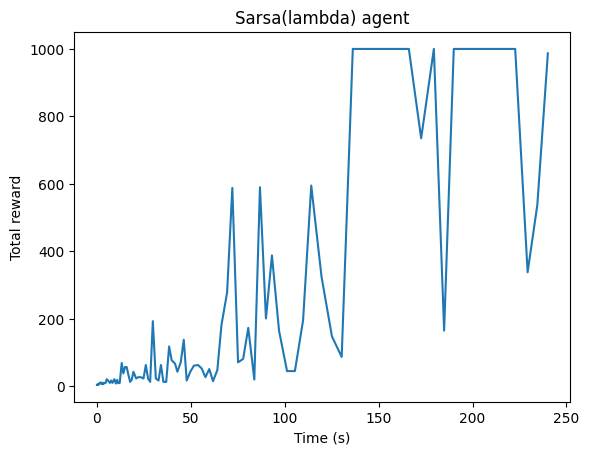

In [27]:
params = SarsaLambdaParams(alpha=0.05, gamma=0.9, num_actions=2, lambd=0.99)
agent, rewards_sarsa_lambda, times_sarsa_lambda = train_sarsa_lambda_time(params, epsilon=0.1, num_episodes=10000, max_train_steps=200, verbose=True)
plt.plot(times_sarsa_lambda, rewards_sarsa_lambda)
plt.xlabel('Time (s)')
plt.ylabel('Total reward')
plt.title('Sarsa(lambda) agent')
plt.show()

100%|██████████| 10000/10000 [00:13<00:00, 768.65it/s]


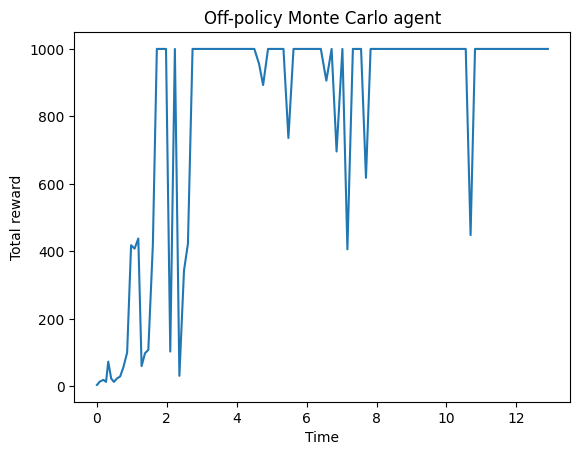

In [26]:
params = MonteCarloParams(num_actions=2, gamma=0.9, epsilon=0.1)
agent, rewards_off_policy_monte_carlo, times_off_policy_monte_carlo = train_off_policy_monte_carlo_time(params, num_episodes=50000, max_train_steps=1000, verbose=True)
plt.plot(times_off_policy_monte_carlo, rewards_off_policy_monte_carlo)
plt.xlabel('Time (s)')
plt.ylabel('Total reward')
plt.title('Off-policy Monte Carlo agent')
plt.show()

100%|██████████| 50000/50000 [02:01<00:00, 412.27it/s]


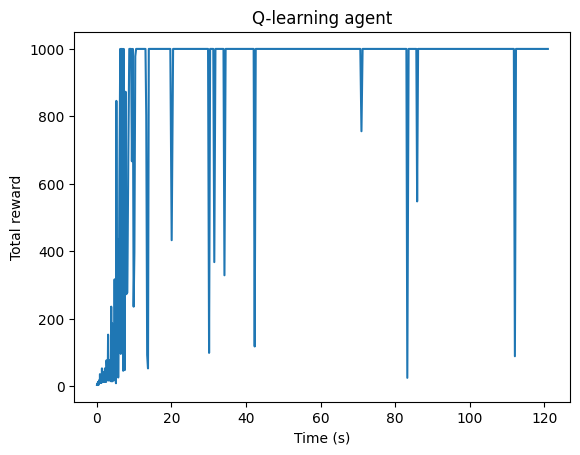

In [32]:
params = QLearningParams(alpha=0.05, gamma=0.9, num_actions=2)
agent, rewards_q_learning, times_q_learning = train_q_learning_time(params, epsilon=0.1, num_episodes=50000, max_train_steps=1000, verbose=True)
plt.plot(times_q_learning, rewards_q_learning)
plt.xlabel('Time (s)')
plt.ylabel('Total reward')
plt.title('Q-learning agent')
plt.show()

100%|██████████| 50000/50000 [01:33<00:00, 537.54it/s] 


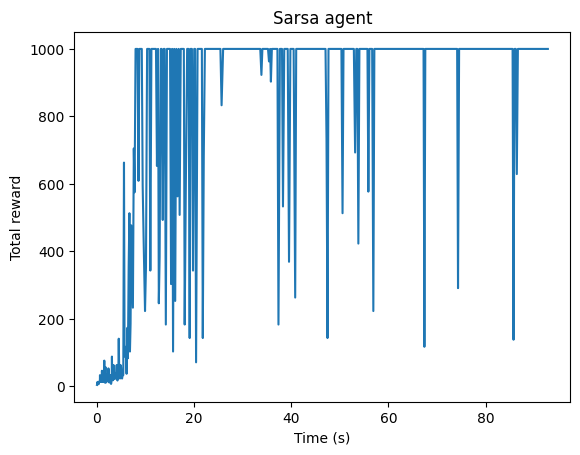

In [29]:
params = SarsaParams(alpha=0.05, gamma=0.9, num_actions=2)
agent, rewards_sarsa, times_sarsa = train_sarsa_time(params, epsilon=0.1, num_episodes=50000, max_train_steps=1000, verbose=True)
plt.plot(times_sarsa, rewards_sarsa)
plt.xlabel('Time (s)')
plt.ylabel('Total reward')
plt.title('Sarsa agent')
plt.show()

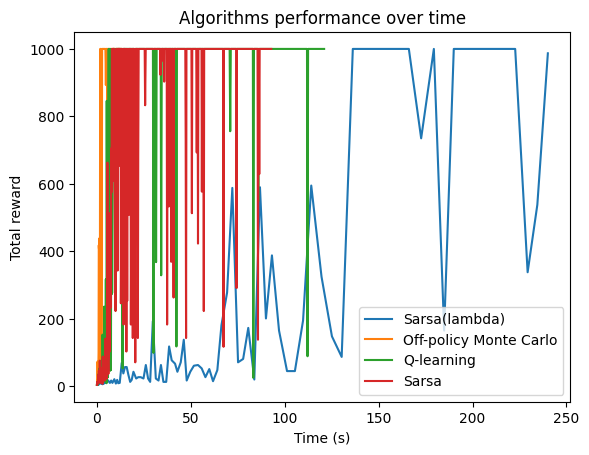

In [36]:
plt.plot(times_sarsa_lambda, rewards_sarsa_lambda, label='Sarsa(lambda)')
plt.plot(times_off_policy_monte_carlo, rewards_off_policy_monte_carlo, label='Off-policy Monte Carlo')
plt.plot(times_q_learning, rewards_q_learning, label='Q-learning')
plt.plot(times_sarsa, rewards_sarsa, label='Sarsa')
plt.xlabel('Time (s)')
plt.ylabel('Total reward')
plt.legend()
plt.title('Algorithms performance over time')
plt.show()

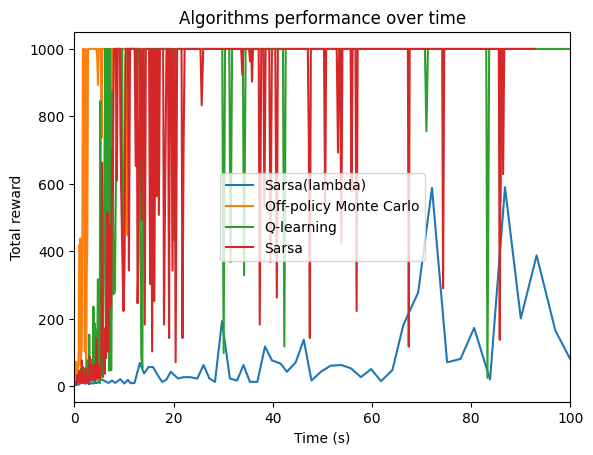

In [37]:
plt.plot(times_sarsa_lambda, rewards_sarsa_lambda, label='Sarsa(lambda)')
plt.plot(times_off_policy_monte_carlo, rewards_off_policy_monte_carlo, label='Off-policy Monte Carlo')
plt.plot(times_q_learning, rewards_q_learning, label='Q-learning')
plt.plot(times_sarsa, rewards_sarsa, label='Sarsa')
plt.xlabel('Time (s)')
plt.ylabel('Total reward')
plt.xlim(0, 100)
plt.legend()
plt.title('Algorithms performance over time')
plt.show()

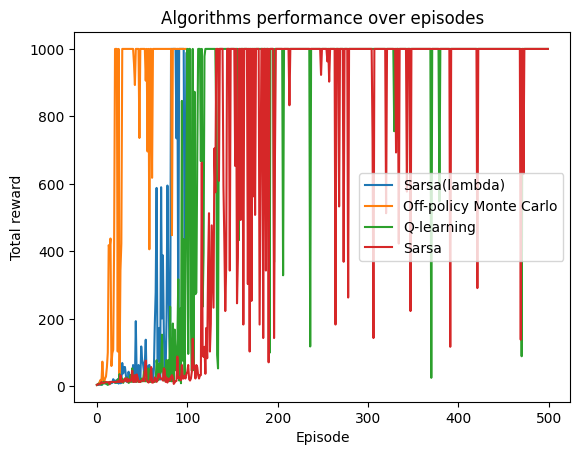

In [38]:
plt.plot(rewards_sarsa_lambda, label='Sarsa(lambda)')
plt.plot(rewards_off_policy_monte_carlo, label='Off-policy Monte Carlo')
plt.plot(rewards_q_learning, label='Q-learning')
plt.plot(rewards_sarsa, label='Sarsa')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.legend()
plt.title('Algorithms performance over episodes')
plt.show()


## Ablation studies

### Off-policy Monte Carlo control

Epsilon: 0.1 - Mean total reward: 769.27215, Std total reward: 331.2522696871045


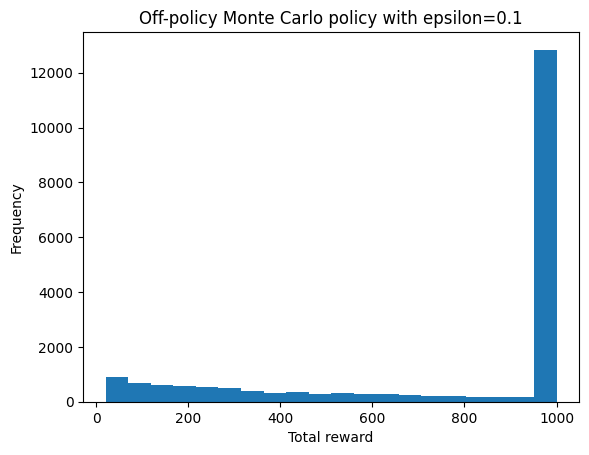

Epsilon: 0.2 - Mean total reward: 430.63175, Std total reward: 331.25228925106046


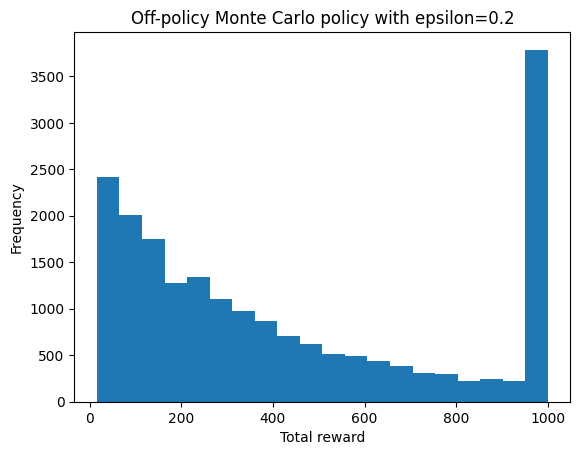

Epsilon: 0.5 - Mean total reward: 170.38185, Std total reward: 160.1417876797776


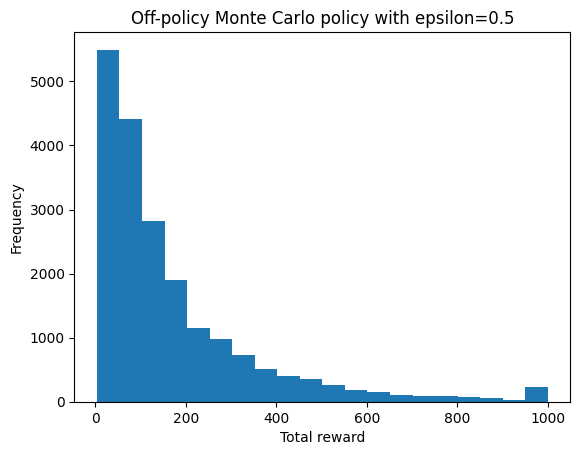

Epsilon: 0.9 - Mean total reward: 59.153400000000005, Std total reward: 49.54712874619483


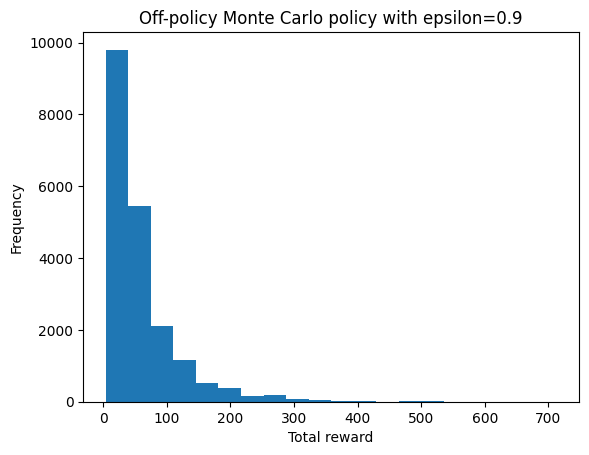

In [39]:
epsilons = [0.1, 0.2, 0.5, 0.9]

total_rewards = np.zeros((len(epsilons), num_performance_runs, num_episodes_for_evaluation))

def evaluate_agent_epsilon(epsilon):
    total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
    for k in range(num_performance_runs):
        params = MonteCarloParams(num_actions=2, gamma=0.9, epsilon=epsilon)
        agent, _ = train_off_policy_monte_carlo(params, num_episodes=10000, max_train_steps=200)
        total_rewards[k] = evaluate_off_policy_monte_carlo(gym.make('TextFlappyBird-v0'), agent)
    return total_rewards

with Pool() as pool:
    for i, total_rewards_for_run in enumerate(pool.imap(evaluate_agent_epsilon, epsilons)):
        total_rewards[i] = total_rewards_for_run

mean_total_rewards = np.mean(total_rewards, axis=1)
std_total_rewards = np.std(total_rewards, axis=1)

for i, epsilon in enumerate(epsilons):
    print(f'Epsilon: {epsilon} - Mean total reward: {np.mean(mean_total_rewards[i])}, Std total reward: {np.mean(std_total_rewards[i])}')
    plt.hist(total_rewards[i].flatten(), bins=20)
    plt.xlabel('Total reward')
    plt.ylabel('Frequency')
    plt.title(f'Off-policy Monte Carlo policy with epsilon={epsilon}')
    plt.show()

Max steps: 100 - Mean total reward: 946.1905999999999, Std total reward: 140.51053768855036


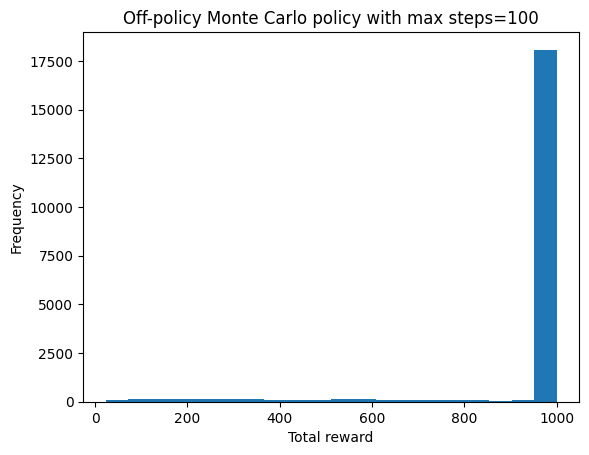

Max steps: 200 - Mean total reward: 754.87985, Std total reward: 347.35298480270336


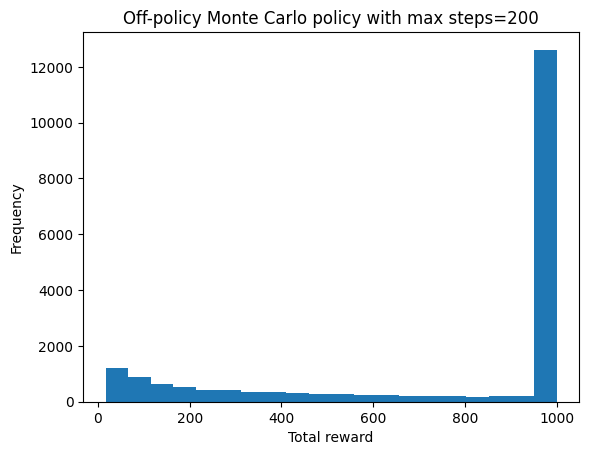

Max steps: 500 - Mean total reward: 764.7899, Std total reward: 316.50484690153496


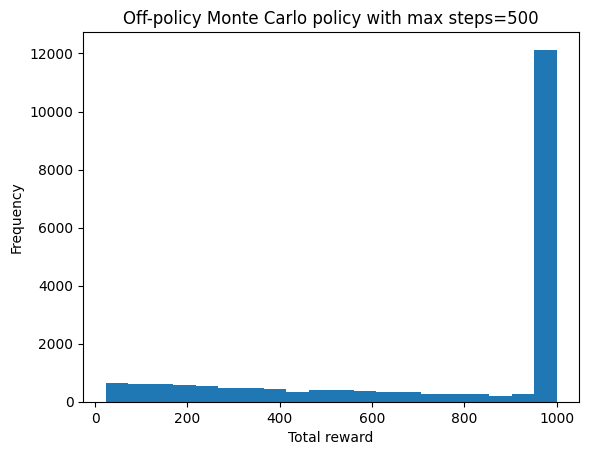

Max steps: 1000 - Mean total reward: 624.1825, Std total reward: 364.37323412733036


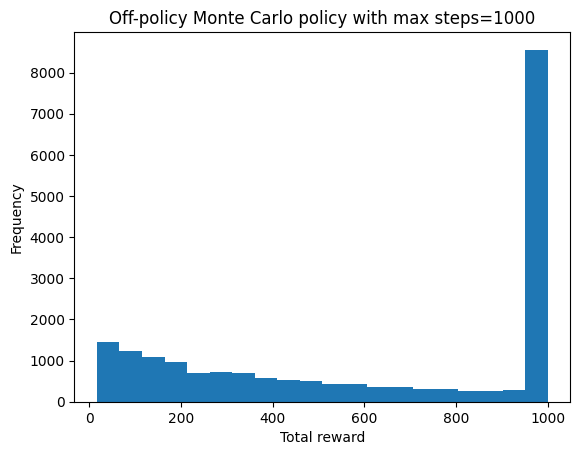

In [40]:
max_steps = [100, 200, 500, 1000]

total_rewards = np.zeros((len(max_steps), num_performance_runs, num_episodes_for_evaluation))

def evaluate_agent_max_steps(max_steps):
    total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
    for k in range(num_performance_runs):
        params = MonteCarloParams(num_actions=2, gamma=0.9, epsilon=0.1)
        agent, _ = train_off_policy_monte_carlo(params, num_episodes=10000, max_train_steps=max_steps)
        total_rewards[k] = evaluate_off_policy_monte_carlo(gym.make('TextFlappyBird-v0'), agent)
    return total_rewards

with Pool() as pool:
    for i, total_rewards_for_run in enumerate(pool.imap(evaluate_agent_max_steps, max_steps)):
        total_rewards[i] = total_rewards_for_run

mean_total_rewards = np.mean(total_rewards, axis=1)
std_total_rewards = np.std(total_rewards, axis=1)

for i, max_step in enumerate(max_steps):
    print(f'Max steps: {max_step} - Mean total reward: {np.mean(mean_total_rewards[i])}, Std total reward: {np.mean(std_total_rewards[i])}')
    plt.hist(total_rewards[i].flatten(), bins=20)
    plt.xlabel('Total reward')
    plt.ylabel('Frequency')
    plt.title(f'Off-policy Monte Carlo policy with max steps={max_step}')
    plt.show()

Num episodes: 1000 - Mean total reward: 227.2934, Std total reward: 219.91352190216352


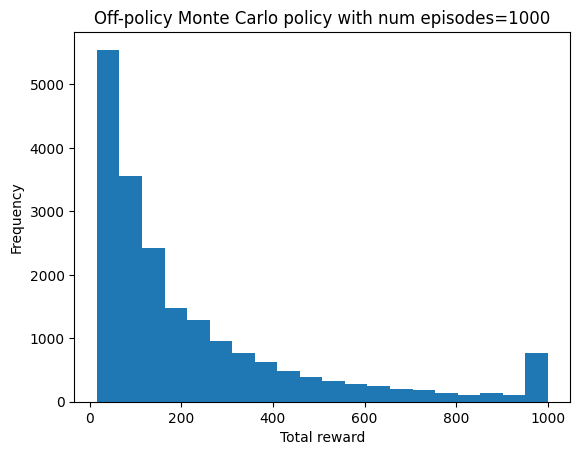

Num episodes: 2000 - Mean total reward: 456.83585, Std total reward: 345.065234947985


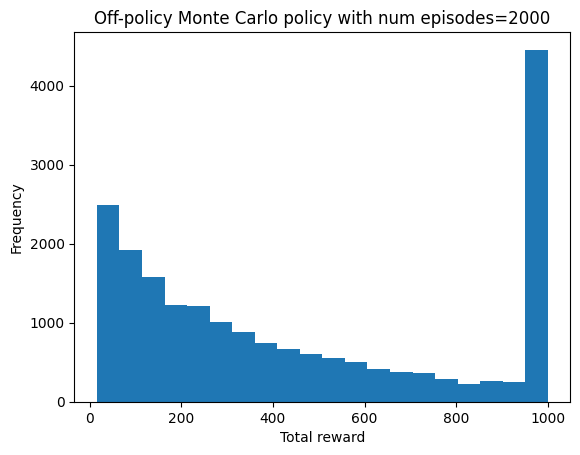

Num episodes: 10000 - Mean total reward: 956.2357499999999, Std total reward: 112.19971693318799


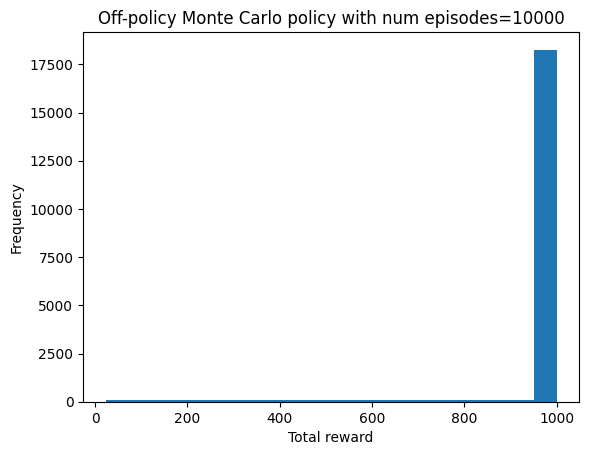

Num episodes: 50000 - Mean total reward: 989.3458499999999, Std total reward: 31.275226398182753


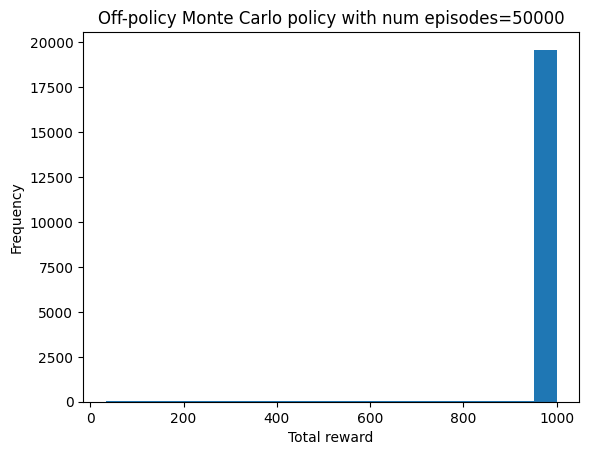

In [41]:
episodes = [1000, 2000, 10000, 50000]

total_rewards = np.zeros((len(episodes), num_performance_runs, num_episodes_for_evaluation))

def evaluate_agent_episodes(num_episodes):
    total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
    for k in range(num_performance_runs):
        params = MonteCarloParams(num_actions=2, gamma=0.9, epsilon=0.1)
        agent, _ = train_off_policy_monte_carlo(params, num_episodes=num_episodes, max_train_steps=100)
        total_rewards[k] = evaluate_off_policy_monte_carlo(gym.make('TextFlappyBird-v0'), agent)
    return total_rewards

with Pool() as pool:
    for i, total_rewards_for_run in enumerate(pool.imap(evaluate_agent_episodes, episodes)):
        total_rewards[i] = total_rewards_for_run

mean_total_rewards = np.mean(total_rewards, axis=1)
std_total_rewards = np.std(total_rewards, axis=1)

for i, num_episode in enumerate(episodes):
    print(f'Num episodes: {num_episode} - Mean total reward: {np.mean(mean_total_rewards[i])}, Std total reward: {np.mean(std_total_rewards[i])}')
    plt.hist(total_rewards[i].flatten(), bins=20)
    plt.xlabel('Total reward')
    plt.ylabel('Frequency')
    plt.title(f'Off-policy Monte Carlo policy with num episodes={num_episode}')
    plt.show()

### Sarsa ($\lambda$)

I did not run the ablation studies for Sarsa ($\lambda$) because it is the longest to run, with about 5 minutes to train for 10000 episodes, meaning that to just evaluate one parameter on 10 training runs (which is still a small number to get a good estimate of the performance) would take about 50 minutes. Since for every hyperparameter I would like to test I would like to test at least 4 values, this would take about 3 hours, multiplied by the number of hyperparameters I would like to test (5 : $\lambda$, $\alpha$, $\epsilon$, number of episodes, max steps per episode), this would take about 15 hours. This is too long for the scope of this assignment, so I will not run the ablation studies for Sarsa ($\lambda$).

Even using multiprocessing, my computer is only running 4 processes at a time, so I would need to run the ablation studies for Sarsa ($\lambda$) on a more powerful computer to get the results in a reasonable time.

### Q-learning

Alpha: 0.001 - Mean total reward: 10.031600000000001, Std total reward: 3.2760973576792014


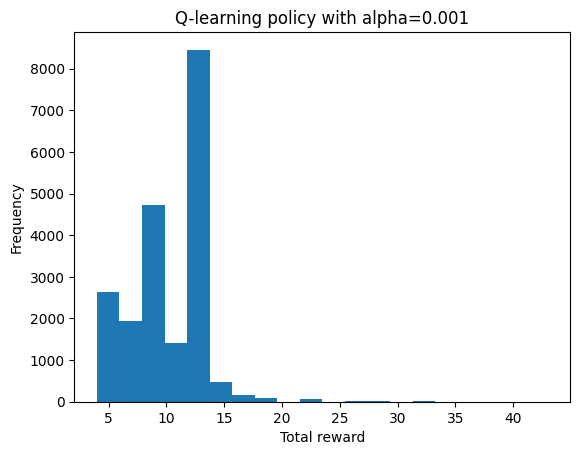

Alpha: 0.01 - Mean total reward: 46.10845, Std total reward: 37.840254212168205


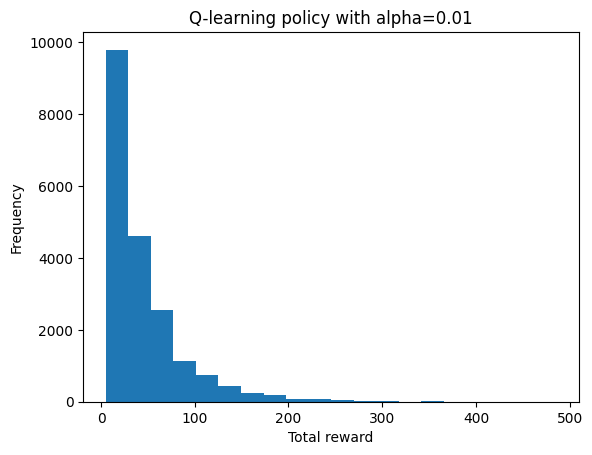

Alpha: 0.1 - Mean total reward: 1000.0, Std total reward: 0.0


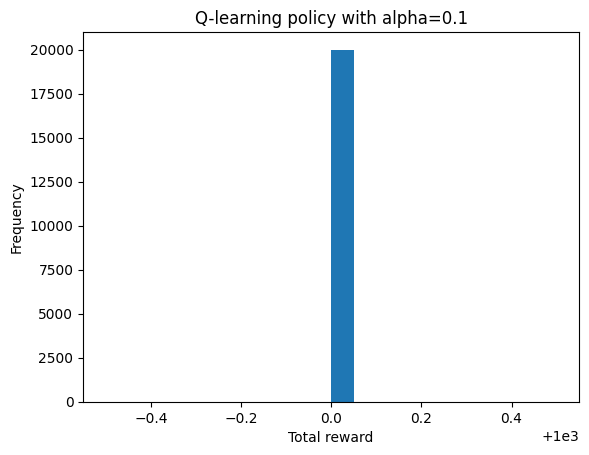

Alpha: 0.5 - Mean total reward: 935.52425, Std total reward: 163.27313658020626


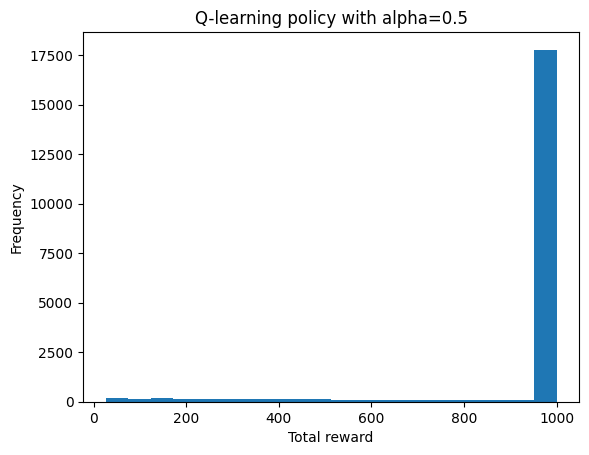

In [42]:
alphas = [0.001, 0.01, 0.1, 0.5]

total_rewards = np.zeros((len(alphas), num_performance_runs, num_episodes_for_evaluation))

def evaluate_agent_alpha(alpha):
    total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
    for k in range(num_performance_runs):
        params = QLearningParams(alpha=alpha, gamma=0.9, num_actions=2)
        agent, _ = train_q_learning(params, epsilon=0.1, num_episodes=50000, max_train_steps=1000)
        total_rewards[k] = evaluate_q_learning(gym.make('TextFlappyBird-v0'), agent)
    return total_rewards

with Pool() as pool:
    for i, total_rewards_for_run in enumerate(pool.imap(evaluate_agent_alpha, alphas)):
        total_rewards[i] = total_rewards_for_run

mean_total_rewards = np.mean(total_rewards, axis=1)
std_total_rewards = np.std(total_rewards, axis=1)

for i, alpha in enumerate(alphas):
    print(f'Alpha: {alpha} - Mean total reward: {np.mean(mean_total_rewards[i])}, Std total reward: {np.mean(std_total_rewards[i])}')
    plt.hist(total_rewards[i].flatten(), bins=20)
    plt.xlabel('Total reward')
    plt.ylabel('Frequency')
    plt.title(f'Q-learning policy with alpha={alpha}')
    plt.show()

Num episodes: 1000 - Mean total reward: 9.930650000000002, Std total reward: 2.651927157514912


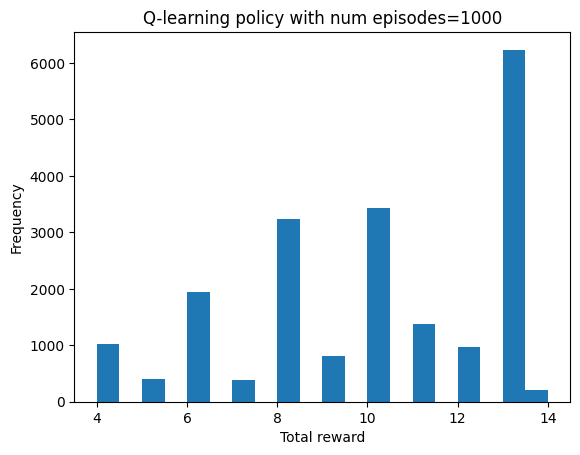

Num episodes: 2000 - Mean total reward: 15.27305, Std total reward: 5.7579242284107295


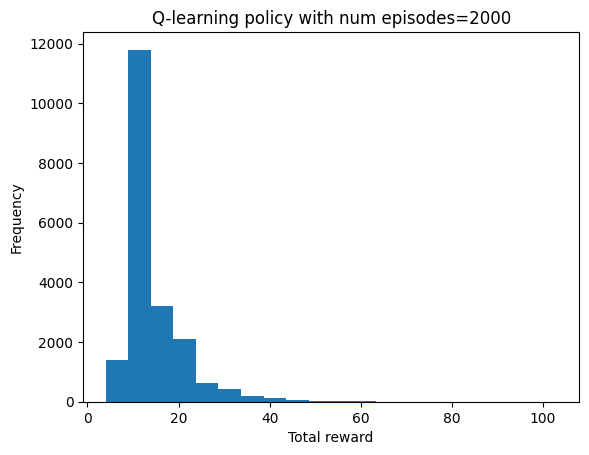

Num episodes: 10000 - Mean total reward: 884.67395, Std total reward: 237.51891617702572


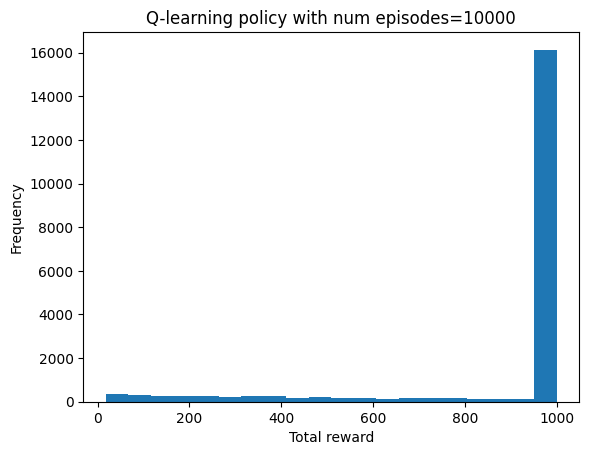

Num episodes: 50000 - Mean total reward: 1000.0, Std total reward: 0.0


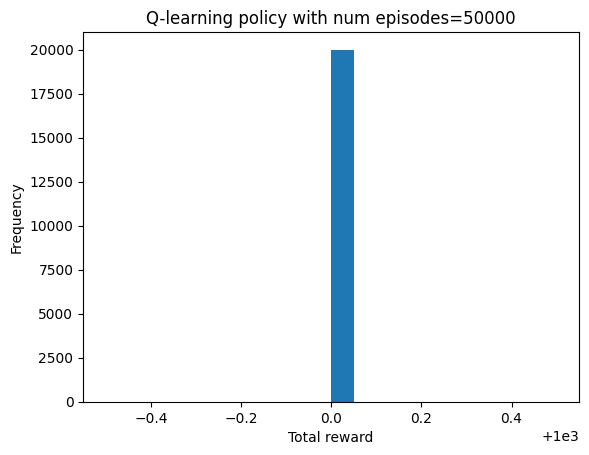

In [16]:
episodes = [1000, 2000, 10000, 50000]

total_rewards = np.zeros((len(episodes), num_performance_runs, num_episodes_for_evaluation))

def evaluate_agent_episodes(num_episodes):
    total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
    for k in range(num_performance_runs):
        params = QLearningParams(alpha=0.1, gamma=0.9, num_actions=2)
        agent, _ = train_q_learning(params, epsilon=0.1, num_episodes=num_episodes, max_train_steps=1000)
        total_rewards[k] = evaluate_q_learning(gym.make('TextFlappyBird-v0'), agent)
    return total_rewards

with Pool() as pool:
    for i, total_rewards_for_run in enumerate(pool.imap(evaluate_agent_episodes, episodes)):
        total_rewards[i] = total_rewards_for_run

mean_total_rewards = np.mean(total_rewards, axis=1)
std_total_rewards = np.std(total_rewards, axis=1)

for i, num_episode in enumerate(episodes):
    print(f'Num episodes: {num_episode} - Mean total reward: {np.mean(mean_total_rewards[i])}, Std total reward: {np.mean(std_total_rewards[i])}')
    plt.hist(total_rewards[i].flatten(), bins=20)
    plt.xlabel('Total reward')
    plt.ylabel('Frequency')
    plt.title(f'Q-learning policy with num episodes={num_episode}')
    plt.show()

## Off environment performance : Monte Carlo control

Env: {'height': 10, 'width': 10, 'pipe_gap': 2} - Mean total reward: 15.70575, Std total reward: 14.174409261859397


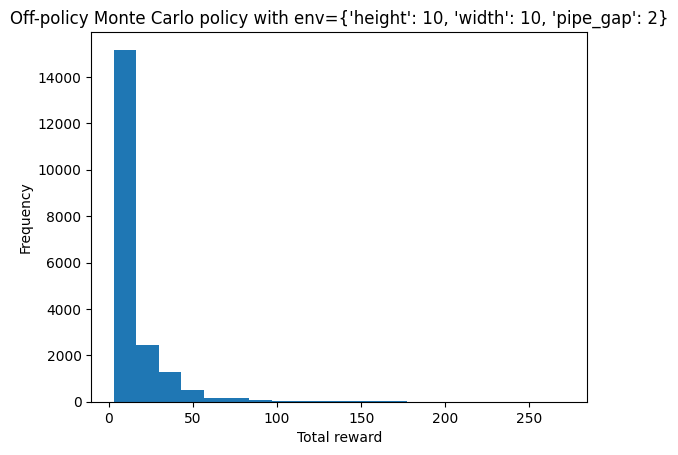

Env: {'height': 15, 'width': 15, 'pipe_gap': 3} - Mean total reward: 35.42960000000001, Std total reward: 30.902903265379077


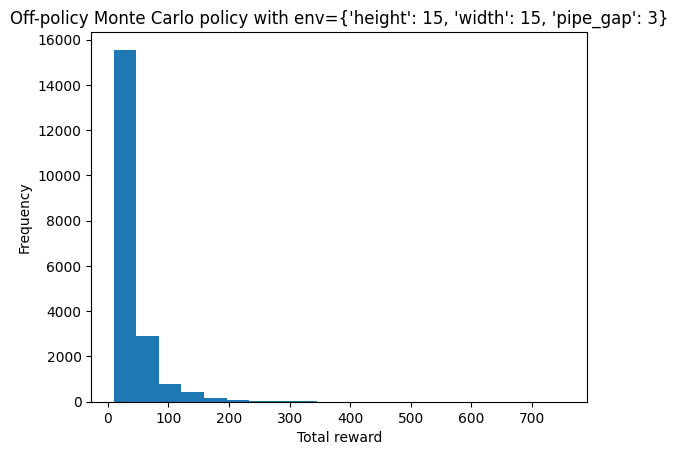

Env: {'height': 20, 'width': 20, 'pipe_gap': 4} - Mean total reward: 206.33745000000002, Std total reward: 231.63790599354263


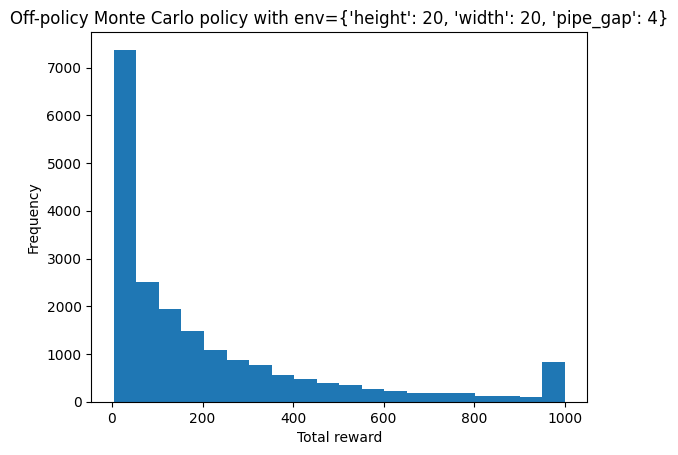

Env: {'height': 25, 'width': 25, 'pipe_gap': 5} - Mean total reward: 6.9763, Std total reward: 5.2864628283715245


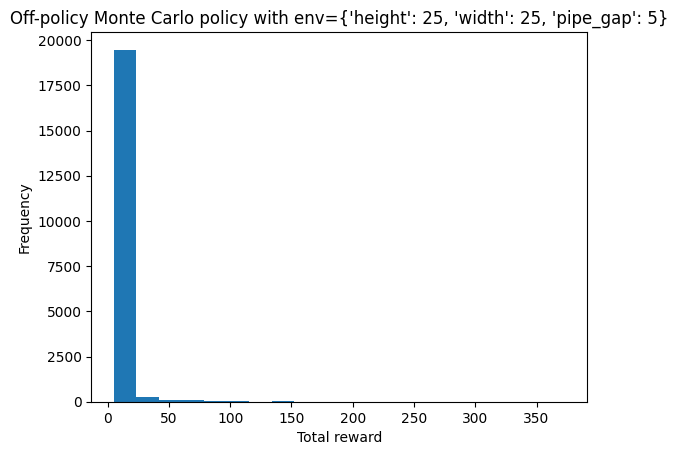

Env: {'height': 15, 'width': 20, 'pipe_gap': 4} - Mean total reward: 972.5471499999999, Std total reward: 75.43218405606723


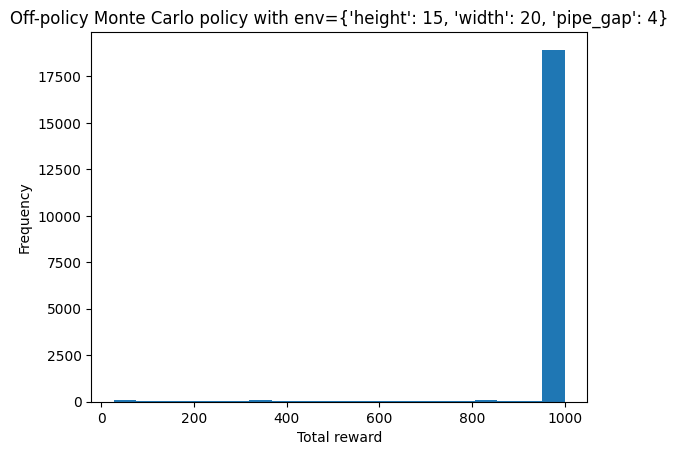

In [15]:
default_env = {'height': 15, 'width': 20, 'pipe_gap': 4}
envs = [{'height': 10, 'width': 10, 'pipe_gap': 2},
        {'height': 15, 'width': 15, 'pipe_gap': 3},
        {'height': 20, 'width': 20, 'pipe_gap': 4},
        {'height': 25, 'width': 25, 'pipe_gap': 5},
        {'height': 15, 'width': 20, 'pipe_gap': 4}]

total_rewards = np.zeros((len(envs), num_performance_runs, num_episodes_for_evaluation))

def evaluate_agent_env(env):
    total_rewards = np.zeros((num_performance_runs, num_episodes_for_evaluation))
    for k in range(num_performance_runs):
        params = MonteCarloParams(num_actions=2, gamma=0.9, epsilon=0.1)
        agent, _ = train_off_policy_monte_carlo(params, num_episodes=10000, max_train_steps=100)
        total_rewards[k] = evaluate_off_policy_monte_carlo(gym.make('TextFlappyBird-v0', **env), agent)
    return total_rewards

with Pool() as pool:
    for i, total_rewards_for_run in enumerate(pool.imap(evaluate_agent_env, envs)):
        total_rewards[i] = total_rewards_for_run

mean_total_rewards = np.mean(total_rewards, axis=1)
std_total_rewards = np.std(total_rewards, axis=1)

for i, env in enumerate(envs):
    print(f'Env: {env} - Mean total reward: {np.mean(mean_total_rewards[i])}, Std total reward: {np.mean(std_total_rewards[i])}')
    plt.hist(total_rewards[i].flatten(), bins=20)
    plt.xlabel('Total reward')
    plt.ylabel('Frequency')
    plt.title(f'Off-policy Monte Carlo policy with env={env}')
    plt.show()